In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [21]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [22]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [23]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [24]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [45]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    #     ##################################################### REPEATING
    #     for _ in range(10):
    #         next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                        reuse=True)
    #         next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                                     reuse=True)
    #         gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                              action_size=action_size, reuse=True)
    #         dones = tf.concat(axis=0, values=[dones[1:], tf.zeros(shape=[1])])
    #         gQs3 = tf.reshape(gQs3, shape=[-1]) * dones
    #         aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                          labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2, (1-dones)

In [46]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [47]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.dones__ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [48]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [49]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [50]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [51]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [52]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [53]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [55]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _, dones__ = sess.run([model.a_loss2, model.a_opt2, model.dones__], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            #print(dones__)
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:1.4075 dloss:1.2406 aloss2:1.3956 exploreP:0.9980
Episode:1 meanR:38.5000 R:57.0000 rate:0.1140 aloss:1.3956 dloss:1.2289 aloss2:1.3905 exploreP:0.9924
Episode:2 meanR:30.0000 R:13.0000 rate:0.0260 aloss:1.3865 dloss:1.2202 aloss2:1.3861 exploreP:0.9911
Episode:3 meanR:25.0000 R:10.0000 rate:0.0200 aloss:1.4018 dloss:1.2215 aloss2:1.3729 exploreP:0.9901
Episode:4 meanR:28.4000 R:42.0000 rate:0.0840 aloss:1.3985 dloss:1.2136 aloss2:1.3943 exploreP:0.9860
Episode:5 meanR:25.5000 R:11.0000 rate:0.0220 aloss:1.3971 dloss:1.2058 aloss2:1.3765 exploreP:0.9850
Episode:6 meanR:23.8571 R:14.0000 rate:0.0280 aloss:1.4032 dloss:1.1953 aloss2:1.4051 exploreP:0.9836
Episode:7 meanR:24.3750 R:28.0000 rate:0.0560 aloss:1.3887 dloss:1.1842 aloss2:1.4396 exploreP:0.9809
Episode:8 meanR:24.4444 R:25.0000 rate:0.0500 aloss:1.3913 dloss:1.1850 aloss2:1.4082 exploreP:0.9785
Episode:9 meanR:22.8000 R:8.0000 rate:0.0160 aloss:1.3976 dloss:1.2009 aloss2:1.41

Episode:80 meanR:21.5802 R:17.0000 rate:0.0340 aloss:1.3941 dloss:0.6673 aloss2:2.8336 exploreP:0.8412
Episode:81 meanR:21.6585 R:28.0000 rate:0.0560 aloss:1.3885 dloss:0.6801 aloss2:2.8790 exploreP:0.8389
Episode:82 meanR:21.6145 R:18.0000 rate:0.0360 aloss:1.3841 dloss:0.6891 aloss2:2.9920 exploreP:0.8374
Episode:83 meanR:21.8214 R:39.0000 rate:0.0780 aloss:1.4071 dloss:0.6796 aloss2:2.8799 exploreP:0.8342
Episode:84 meanR:21.8471 R:24.0000 rate:0.0480 aloss:1.3924 dloss:0.6704 aloss2:3.0599 exploreP:0.8322
Episode:85 meanR:21.7442 R:13.0000 rate:0.0260 aloss:1.3926 dloss:0.6721 aloss2:3.0336 exploreP:0.8311
Episode:86 meanR:21.7126 R:19.0000 rate:0.0380 aloss:1.4062 dloss:0.6636 aloss2:2.9219 exploreP:0.8296
Episode:87 meanR:21.6818 R:19.0000 rate:0.0380 aloss:1.3976 dloss:0.6483 aloss2:3.0250 exploreP:0.8280
Episode:88 meanR:21.8202 R:34.0000 rate:0.0680 aloss:1.4075 dloss:0.6426 aloss2:3.1073 exploreP:0.8253
Episode:89 meanR:21.9667 R:35.0000 rate:0.0700 aloss:1.3956 dloss:0.6717 

Episode:159 meanR:25.2000 R:18.0000 rate:0.0360 aloss:1.3729 dloss:0.5233 aloss2:4.9257 exploreP:0.6908
Episode:160 meanR:25.2900 R:37.0000 rate:0.0740 aloss:1.3721 dloss:0.4974 aloss2:4.9973 exploreP:0.6883
Episode:161 meanR:25.0100 R:40.0000 rate:0.0800 aloss:1.3739 dloss:0.4946 aloss2:4.9851 exploreP:0.6856
Episode:162 meanR:25.0000 R:12.0000 rate:0.0240 aloss:1.3957 dloss:0.4984 aloss2:4.9261 exploreP:0.6848
Episode:163 meanR:25.3600 R:57.0000 rate:0.1140 aloss:1.3706 dloss:0.4872 aloss2:5.0001 exploreP:0.6810
Episode:164 meanR:25.5700 R:40.0000 rate:0.0800 aloss:1.3765 dloss:0.5049 aloss2:5.1271 exploreP:0.6783
Episode:165 meanR:25.4800 R:32.0000 rate:0.0640 aloss:1.3732 dloss:0.5037 aloss2:5.1192 exploreP:0.6761
Episode:166 meanR:25.6500 R:32.0000 rate:0.0640 aloss:1.3698 dloss:0.5108 aloss2:5.1286 exploreP:0.6740
Episode:167 meanR:25.6100 R:38.0000 rate:0.0760 aloss:1.3756 dloss:0.4898 aloss2:5.1291 exploreP:0.6715
Episode:168 meanR:25.6100 R:14.0000 rate:0.0280 aloss:1.3820 dlo

Episode:238 meanR:47.4300 R:14.0000 rate:0.0280 aloss:1.3970 dloss:0.5264 aloss2:5.3390 exploreP:0.4663
Episode:239 meanR:48.0700 R:81.0000 rate:0.1620 aloss:1.3835 dloss:0.5045 aloss2:5.3218 exploreP:0.4626
Episode:240 meanR:48.5300 R:91.0000 rate:0.1820 aloss:1.3836 dloss:0.5155 aloss2:5.3167 exploreP:0.4585
Episode:241 meanR:48.9600 R:66.0000 rate:0.1320 aloss:1.3857 dloss:0.4764 aloss2:5.3084 exploreP:0.4555
Episode:242 meanR:48.8900 R:87.0000 rate:0.1740 aloss:1.4000 dloss:0.5069 aloss2:5.3309 exploreP:0.4517
Episode:243 meanR:49.2000 R:47.0000 rate:0.0940 aloss:1.4176 dloss:0.5102 aloss2:5.2783 exploreP:0.4496
Episode:244 meanR:49.6000 R:61.0000 rate:0.1220 aloss:1.4046 dloss:0.4910 aloss2:5.3176 exploreP:0.4469
Episode:245 meanR:49.7300 R:39.0000 rate:0.0780 aloss:1.3832 dloss:0.5251 aloss2:5.3291 exploreP:0.4452
Episode:246 meanR:49.4200 R:23.0000 rate:0.0460 aloss:1.3911 dloss:0.4560 aloss2:5.3151 exploreP:0.4442
Episode:247 meanR:49.6400 R:53.0000 rate:0.1060 aloss:1.4077 dlo

Episode:317 meanR:79.0900 R:80.0000 rate:0.1600 aloss:1.4268 dloss:0.4980 aloss2:5.2603 exploreP:0.2491
Episode:318 meanR:79.4800 R:117.0000 rate:0.2340 aloss:1.4142 dloss:0.5314 aloss2:5.2693 exploreP:0.2463
Episode:319 meanR:80.2700 R:134.0000 rate:0.2680 aloss:1.4092 dloss:0.5346 aloss2:5.2445 exploreP:0.2432
Episode:320 meanR:80.5100 R:102.0000 rate:0.2040 aloss:1.4167 dloss:0.5198 aloss2:5.2137 exploreP:0.2408
Episode:321 meanR:80.6000 R:129.0000 rate:0.2580 aloss:1.4237 dloss:0.5231 aloss2:5.1950 exploreP:0.2378
Episode:322 meanR:81.1500 R:96.0000 rate:0.1920 aloss:1.4248 dloss:0.4906 aloss2:5.2531 exploreP:0.2357
Episode:323 meanR:81.6800 R:95.0000 rate:0.1900 aloss:1.4493 dloss:0.4972 aloss2:5.2873 exploreP:0.2335
Episode:324 meanR:81.2800 R:85.0000 rate:0.1700 aloss:1.4062 dloss:0.5222 aloss2:5.3143 exploreP:0.2316
Episode:325 meanR:82.0000 R:116.0000 rate:0.2320 aloss:1.4081 dloss:0.5411 aloss2:5.2790 exploreP:0.2291
Episode:326 meanR:83.3900 R:151.0000 rate:0.3020 aloss:1.41

Episode:395 meanR:162.5800 R:133.0000 rate:0.2660 aloss:1.3968 dloss:0.7090 aloss2:4.5185 exploreP:0.0669
Episode:396 meanR:164.3400 R:212.0000 rate:0.4240 aloss:1.3941 dloss:0.6774 aloss2:4.4868 exploreP:0.0657
Episode:397 meanR:166.8000 R:316.0000 rate:0.6320 aloss:1.3986 dloss:0.6802 aloss2:4.4747 exploreP:0.0639
Episode:398 meanR:168.5600 R:215.0000 rate:0.4300 aloss:1.3749 dloss:0.7465 aloss2:4.4474 exploreP:0.0628
Episode:399 meanR:169.9700 R:248.0000 rate:0.4960 aloss:1.3961 dloss:0.7454 aloss2:4.3923 exploreP:0.0615
Episode:400 meanR:170.8500 R:159.0000 rate:0.3180 aloss:1.4040 dloss:0.6946 aloss2:4.3809 exploreP:0.0607
Episode:401 meanR:175.2700 R:500.0000 rate:1.0000 aloss:1.3934 dloss:0.7242 aloss2:4.3496 exploreP:0.0582
Episode:402 meanR:176.9900 R:267.0000 rate:0.5340 aloss:1.4033 dloss:0.7102 aloss2:4.3606 exploreP:0.0570
Episode:403 meanR:177.6200 R:180.0000 rate:0.3600 aloss:1.4112 dloss:0.6979 aloss2:4.3622 exploreP:0.0561
Episode:404 meanR:181.4000 R:500.0000 rate:1.0

Episode:473 meanR:299.0600 R:500.0000 rate:1.0000 aloss:1.3187 dloss:1.0058 aloss2:3.3324 exploreP:0.0153
Episode:474 meanR:302.2600 R:500.0000 rate:1.0000 aloss:1.3191 dloss:1.0008 aloss2:3.3113 exploreP:0.0150
Episode:475 meanR:303.5500 R:334.0000 rate:0.6680 aloss:1.3305 dloss:0.9601 aloss2:3.3810 exploreP:0.0149
Episode:476 meanR:305.1800 R:500.0000 rate:1.0000 aloss:1.3221 dloss:1.0025 aloss2:3.3392 exploreP:0.0146
Episode:477 meanR:308.2200 R:500.0000 rate:1.0000 aloss:1.3079 dloss:1.0260 aloss2:3.2660 exploreP:0.0144
Episode:478 meanR:308.5000 R:500.0000 rate:1.0000 aloss:1.3216 dloss:1.0083 aloss2:3.2209 exploreP:0.0142
Episode:479 meanR:311.4700 R:500.0000 rate:1.0000 aloss:1.3037 dloss:1.0339 aloss2:3.2190 exploreP:0.0140
Episode:480 meanR:311.4700 R:500.0000 rate:1.0000 aloss:1.3317 dloss:0.9838 aloss2:3.2844 exploreP:0.0138
Episode:481 meanR:313.8500 R:500.0000 rate:1.0000 aloss:1.3121 dloss:1.0137 aloss2:3.2515 exploreP:0.0136
Episode:482 meanR:317.0900 R:500.0000 rate:1.0

Episode:551 meanR:447.0400 R:263.0000 rate:0.5260 aloss:1.1695 dloss:1.2698 aloss2:2.2260 exploreP:0.0102
Episode:552 meanR:448.9500 R:475.0000 rate:0.9500 aloss:1.1696 dloss:1.2683 aloss2:2.2076 exploreP:0.0101
Episode:553 meanR:445.5900 R:164.0000 rate:0.3280 aloss:1.1709 dloss:1.2517 aloss2:2.2077 exploreP:0.0101
Episode:554 meanR:446.3100 R:443.0000 rate:0.8860 aloss:1.1782 dloss:1.2496 aloss2:2.2548 exploreP:0.0101
Episode:555 meanR:443.8400 R:253.0000 rate:0.5060 aloss:1.1751 dloss:1.2580 aloss2:2.2260 exploreP:0.0101
Episode:556 meanR:443.8400 R:500.0000 rate:1.0000 aloss:1.1806 dloss:1.2229 aloss2:2.3178 exploreP:0.0101
Episode:557 meanR:446.6800 R:500.0000 rate:1.0000 aloss:1.1809 dloss:1.2626 aloss2:2.2657 exploreP:0.0101
Episode:558 meanR:446.0300 R:435.0000 rate:0.8700 aloss:1.1580 dloss:1.2722 aloss2:2.1868 exploreP:0.0101
Episode:559 meanR:449.2800 R:500.0000 rate:1.0000 aloss:1.1631 dloss:1.2763 aloss2:2.1780 exploreP:0.0101
Episode:560 meanR:446.0800 R:180.0000 rate:0.3

Episode:629 meanR:343.5700 R:101.0000 rate:0.2020 aloss:1.0786 dloss:1.3435 aloss2:1.6702 exploreP:0.0100
Episode:630 meanR:343.5700 R:500.0000 rate:1.0000 aloss:1.0802 dloss:1.3441 aloss2:1.6696 exploreP:0.0100
Episode:631 meanR:343.5700 R:500.0000 rate:1.0000 aloss:1.0837 dloss:1.3459 aloss2:1.6647 exploreP:0.0100
Episode:632 meanR:343.5700 R:500.0000 rate:1.0000 aloss:1.0692 dloss:1.3443 aloss2:1.6568 exploreP:0.0100
Episode:633 meanR:342.9300 R:179.0000 rate:0.3580 aloss:1.0883 dloss:1.3437 aloss2:1.6634 exploreP:0.0100
Episode:634 meanR:342.9300 R:500.0000 rate:1.0000 aloss:1.0742 dloss:1.3456 aloss2:1.6559 exploreP:0.0100
Episode:635 meanR:343.9300 R:500.0000 rate:1.0000 aloss:1.0740 dloss:1.3431 aloss2:1.6663 exploreP:0.0100
Episode:636 meanR:343.9300 R:500.0000 rate:1.0000 aloss:1.0763 dloss:1.3441 aloss2:1.6461 exploreP:0.0100
Episode:637 meanR:344.6100 R:500.0000 rate:1.0000 aloss:1.0753 dloss:1.3435 aloss2:1.6351 exploreP:0.0100
Episode:638 meanR:344.6100 R:500.0000 rate:1.0

Episode:707 meanR:421.7300 R:500.0000 rate:1.0000 aloss:1.0575 dloss:1.0377 aloss2:2.2515 exploreP:0.0100
Episode:708 meanR:417.9600 R:123.0000 rate:0.2460 aloss:1.0576 dloss:1.0276 aloss2:2.2675 exploreP:0.0100
Episode:709 meanR:417.9600 R:500.0000 rate:1.0000 aloss:1.0574 dloss:1.0395 aloss2:2.2168 exploreP:0.0100
Episode:710 meanR:417.4400 R:448.0000 rate:0.8960 aloss:1.0602 dloss:1.0372 aloss2:2.2493 exploreP:0.0100
Episode:711 meanR:417.4400 R:500.0000 rate:1.0000 aloss:1.0618 dloss:1.0317 aloss2:2.2613 exploreP:0.0100
Episode:712 meanR:417.4400 R:500.0000 rate:1.0000 aloss:1.0591 dloss:1.0234 aloss2:2.3177 exploreP:0.0100
Episode:713 meanR:418.9100 R:500.0000 rate:1.0000 aloss:1.0579 dloss:1.0130 aloss2:2.3278 exploreP:0.0100
Episode:714 meanR:418.9100 R:500.0000 rate:1.0000 aloss:1.0615 dloss:1.0031 aloss2:2.3484 exploreP:0.0100
Episode:715 meanR:417.1800 R:327.0000 rate:0.6540 aloss:1.0656 dloss:0.9998 aloss2:2.3656 exploreP:0.0100
Episode:716 meanR:419.4900 R:500.0000 rate:1.0

Episode:785 meanR:389.5000 R:94.0000 rate:0.1880 aloss:1.0530 dloss:0.5653 aloss2:4.8282 exploreP:0.0100
Episode:786 meanR:389.5000 R:500.0000 rate:1.0000 aloss:1.0591 dloss:0.5799 aloss2:5.1548 exploreP:0.0100
Episode:787 meanR:386.0400 R:154.0000 rate:0.3080 aloss:1.0746 dloss:0.5712 aloss2:5.0794 exploreP:0.0100
Episode:788 meanR:385.2000 R:416.0000 rate:0.8320 aloss:1.0729 dloss:0.6014 aloss2:5.1078 exploreP:0.0100
Episode:789 meanR:382.3100 R:211.0000 rate:0.4220 aloss:1.0765 dloss:0.6166 aloss2:5.0100 exploreP:0.0100
Episode:790 meanR:382.3100 R:500.0000 rate:1.0000 aloss:1.0752 dloss:0.6287 aloss2:5.2109 exploreP:0.0100
Episode:791 meanR:385.3900 R:500.0000 rate:1.0000 aloss:1.0752 dloss:0.6147 aloss2:4.9612 exploreP:0.0100
Episode:792 meanR:382.8400 R:245.0000 rate:0.4900 aloss:1.0746 dloss:0.6273 aloss2:5.0624 exploreP:0.0100
Episode:793 meanR:379.3200 R:148.0000 rate:0.2960 aloss:1.0781 dloss:0.6332 aloss2:5.1374 exploreP:0.0100
Episode:794 meanR:382.5900 R:500.0000 rate:1.00

Episode:863 meanR:358.6600 R:243.0000 rate:0.4860 aloss:1.0376 dloss:0.2937 aloss2:9.7869 exploreP:0.0100
Episode:864 meanR:358.1200 R:163.0000 rate:0.3260 aloss:1.0416 dloss:0.3105 aloss2:11.4771 exploreP:0.0100
Episode:865 meanR:358.1200 R:500.0000 rate:1.0000 aloss:1.0349 dloss:0.2855 aloss2:10.1983 exploreP:0.0100
Episode:866 meanR:358.1200 R:500.0000 rate:1.0000 aloss:1.0335 dloss:0.2866 aloss2:10.4236 exploreP:0.0100
Episode:867 meanR:357.1900 R:407.0000 rate:0.8140 aloss:1.0335 dloss:0.2814 aloss2:10.8788 exploreP:0.0100
Episode:868 meanR:355.5200 R:333.0000 rate:0.6660 aloss:1.0250 dloss:0.2544 aloss2:11.1057 exploreP:0.0100
Episode:869 meanR:358.6700 R:500.0000 rate:1.0000 aloss:1.0312 dloss:0.2355 aloss2:11.8183 exploreP:0.0100
Episode:870 meanR:359.1700 R:180.0000 rate:0.3600 aloss:1.0273 dloss:0.2169 aloss2:10.9960 exploreP:0.0100
Episode:871 meanR:357.9500 R:19.0000 rate:0.0380 aloss:1.0331 dloss:0.2185 aloss2:10.9447 exploreP:0.0100
Episode:872 meanR:357.9500 R:500.0000 r

Episode:940 meanR:312.8900 R:10.0000 rate:0.0200 aloss:1.0089 dloss:0.2442 aloss2:22.6253 exploreP:0.0100
Episode:941 meanR:316.9600 R:500.0000 rate:1.0000 aloss:1.0243 dloss:0.2287 aloss2:22.4510 exploreP:0.0100
Episode:942 meanR:316.3900 R:187.0000 rate:0.3740 aloss:1.0213 dloss:0.2261 aloss2:22.6064 exploreP:0.0100
Episode:943 meanR:315.7300 R:22.0000 rate:0.0440 aloss:1.0144 dloss:0.2216 aloss2:23.5620 exploreP:0.0100
Episode:944 meanR:310.9200 R:19.0000 rate:0.0380 aloss:1.0290 dloss:0.2294 aloss2:22.8937 exploreP:0.0100
Episode:945 meanR:315.4200 R:500.0000 rate:1.0000 aloss:1.0239 dloss:0.2436 aloss2:22.5066 exploreP:0.0100
Episode:946 meanR:319.4200 R:500.0000 rate:1.0000 aloss:1.0274 dloss:0.2713 aloss2:23.0589 exploreP:0.0100
Episode:947 meanR:319.4200 R:500.0000 rate:1.0000 aloss:1.0271 dloss:0.2954 aloss2:23.3247 exploreP:0.0100
Episode:948 meanR:321.2700 R:500.0000 rate:1.0000 aloss:1.0257 dloss:0.2888 aloss2:24.9020 exploreP:0.0100
Episode:949 meanR:323.9900 R:500.0000 ra

Episode:1017 meanR:414.2500 R:500.0000 rate:1.0000 aloss:1.0998 dloss:0.1213 aloss2:29.2461 exploreP:0.0100
Episode:1018 meanR:415.3500 R:500.0000 rate:1.0000 aloss:1.0986 dloss:0.1352 aloss2:27.0736 exploreP:0.0100
Episode:1019 meanR:415.3500 R:500.0000 rate:1.0000 aloss:1.1029 dloss:0.1398 aloss2:27.1843 exploreP:0.0100
Episode:1020 meanR:420.0500 R:500.0000 rate:1.0000 aloss:1.0965 dloss:0.1390 aloss2:26.4823 exploreP:0.0100
Episode:1021 meanR:424.0700 R:500.0000 rate:1.0000 aloss:1.0995 dloss:0.1469 aloss2:26.5193 exploreP:0.0100
Episode:1022 meanR:424.0700 R:500.0000 rate:1.0000 aloss:1.0938 dloss:0.1327 aloss2:26.4863 exploreP:0.0100
Episode:1023 meanR:428.8300 R:500.0000 rate:1.0000 aloss:1.0904 dloss:0.1418 aloss2:25.6513 exploreP:0.0100
Episode:1024 meanR:431.3500 R:500.0000 rate:1.0000 aloss:1.0890 dloss:0.1418 aloss2:25.8822 exploreP:0.0100
Episode:1025 meanR:435.5600 R:500.0000 rate:1.0000 aloss:1.0920 dloss:0.1651 aloss2:26.0002 exploreP:0.0100
Episode:1026 meanR:435.5600 

Episode:1093 meanR:478.6900 R:500.0000 rate:1.0000 aloss:1.0873 dloss:0.1742 aloss2:39.0467 exploreP:0.0100
Episode:1094 meanR:478.6900 R:500.0000 rate:1.0000 aloss:1.0862 dloss:0.1727 aloss2:38.5820 exploreP:0.0100
Episode:1095 meanR:478.6900 R:500.0000 rate:1.0000 aloss:1.0964 dloss:0.1838 aloss2:40.8284 exploreP:0.0100
Episode:1096 meanR:479.9800 R:500.0000 rate:1.0000 aloss:1.0905 dloss:0.1769 aloss2:38.5813 exploreP:0.0100
Episode:1097 meanR:479.9800 R:500.0000 rate:1.0000 aloss:1.0918 dloss:0.1684 aloss2:39.2308 exploreP:0.0100
Episode:1098 meanR:481.6100 R:500.0000 rate:1.0000 aloss:1.0834 dloss:0.1764 aloss2:37.8126 exploreP:0.0100
Episode:1099 meanR:483.5700 R:500.0000 rate:1.0000 aloss:1.0922 dloss:0.1828 aloss2:39.9781 exploreP:0.0100
Episode:1100 meanR:484.8700 R:500.0000 rate:1.0000 aloss:1.0878 dloss:0.1788 aloss2:37.3363 exploreP:0.0100
Episode:1101 meanR:485.8500 R:500.0000 rate:1.0000 aloss:1.0940 dloss:0.1837 aloss2:39.0964 exploreP:0.0100
Episode:1102 meanR:487.1400 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

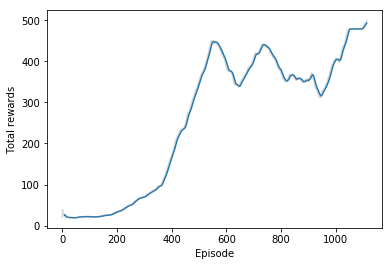

In [57]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

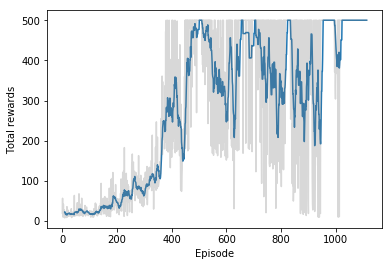

In [58]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.